In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# 1. Load and format data

In [2]:
#load spend data
spend_files = list(Path('data_files/raw/').glob('*spend.csv'))
spend_dfs = {f.stem: pd.read_csv(f) for f in spend_files}

#load sales data
sales_file = Path('data_files/raw/sales_data.csv')
sales_df = pd.read_csv(sales_file)
sales_df.head()

,date,sales
0,2022-01-01,208284.0
1,2022-01-02,222428.0
2,2022-01-03,224317.0
3,2022-01-04,236782.0
4,2022-01-05,247838.0


In [3]:
#rename spend columns and format date
for name, df in spend_dfs.items():
    df.columns = ['date', name] 
    df['date'] = pd.to_datetime(df['date'])

#rename sales columns and format date
sales_df.columns = ['date', 'sales']
sales_df['date'] = pd.to_datetime(sales_df['date'])

In [4]:
#merge spend on date
merged_df = list(spend_dfs.values())[0]
for df in list(spend_dfs.values())[1:]:
    merged_df = pd.merge(merged_df, df, on='date', how='outer')
    
#merge sales
merged_df = pd.merge(merged_df, sales_df, on='date', how='outer')
merged_df.head()

,date,social_media_spend,search_spend,radio_spend,outdoor_spend,tv_spend,print_spend,sales
0,2022-01-01,3563.0,4707.0,0.0,14895.0,18395.0,9855.0,208284.0
1,2022-01-02,2059.0,3030.0,0.0,14384.0,20278.0,0.0,222428.0
2,2022-01-03,2583.0,3635.0,10139.0,16561.0,23934.0,0.0,224317.0
3,2022-01-04,1948.0,4332.0,8379.0,11724.0,21894.0,0.0,236782.0
4,2022-01-05,4568.0,3749.0,9717.0,11980.0,20217.0,0.0,247838.0


# 2. Inspect raw data

In [5]:
print(f"Data shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

Data shape: (365, 2)
Date range: 2022-01-01 00:00:00 to 2022-12-31 00:00:00


In [6]:
print("Negative values:\n", (merged_df.drop(columns=['date']) < 0).sum())
print("\nMissing values:\n", merged_df.isna().sum())

Negative values:
 social_media_spend    8
search_spend          1
radio_spend           1
outdoor_spend         1
tv_spend              0
print_spend           0
sales                 4
dtype: int64

Missing values:
 date                   0
social_media_spend     8
search_spend           7
radio_spend           11
outdoor_spend          6
tv_spend               7
print_spend           11
sales                  5
dtype: int64


In [7]:
display(merged_df.describe())

,date,social_media_spend,search_spend,radio_spend,outdoor_spend,tv_spend,print_spend,sales
count,365,357.000000,358.000000,354.000000,3.590000e+02,358.000000,354.000000,3.600000e+02
mean,2022-07-01 23:59:59.999999744,3786.109244,4881.924581,2435.322034,8.992510e+03,8376.321229,1633.242938,1.955590e+05
min,2022-01-01 00:00:00,-3654.000000,-4598.000000,-9907.000000,-1.807300e+04,0.000000,0.000000,-2.355860e+05
25%,2022-04-02 00:00:00,2374.000000,3320.500000,0.000000,0.000000e+00,0.000000,0.000000,1.596880e+05
50%,2022-07-02 00:00:00,2996.000000,3938.500000,0.000000,0.000000e+00,0.000000,0.000000,1.836975e+05
75%,2022-10-01 00:00:00,3548.000000,4461.750000,6094.500000,1.326800e+04,18557.000000,0.000000,2.074058e+05
max,2022-12-31 00:00:00,283385.000000,225600.000000,12934.000000,1.187040e+06,30466.000000,202316.000000,7.111468e+06
std,NaN,15287.052063,14279.910696,3915.324561,6.279623e+04,10329.322304,11226.010232,3.699124e+05


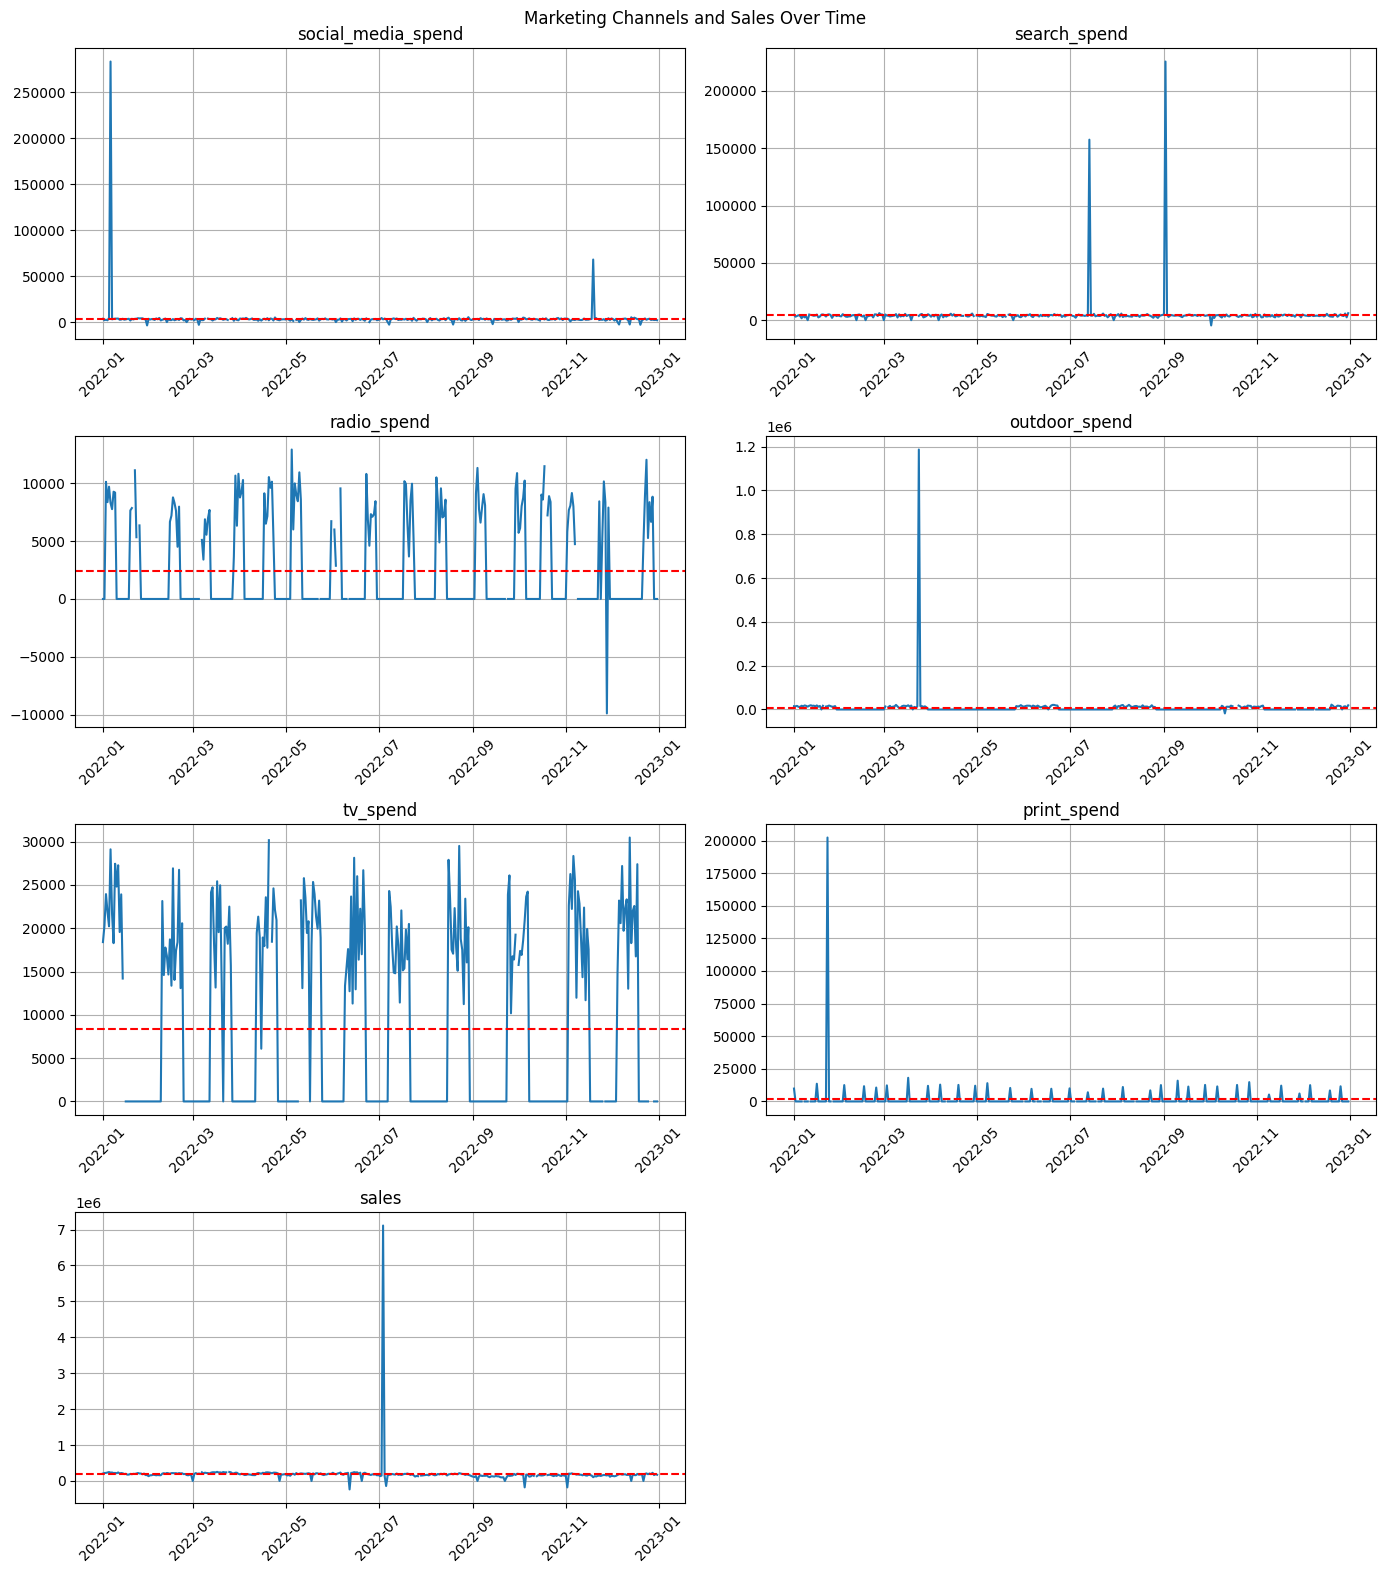

In [8]:
fig, axes = plt.subplots(4, 2, figsize=(14, 16))
fig.suptitle("Marketing Channels and Sales Over Time")

axes = axes.flatten()

for i, col in enumerate([col for col in merged_df.columns if col != 'date']):
    if i < 7:  
        ax = axes[i]
        ax.plot(merged_df['date'], merged_df[col], label=col)
        ax.axhline(y=merged_df[col].mean(), color='r', linestyle='--', label='Mean')
        ax.set_title(col)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True)

fig.delaxes(axes[7])
plt.tight_layout()
plt.show()


In [9]:
# Calculate correlations with sales
correlations = merged_df.drop(columns=['date']).corr()['sales'].sort_values(ascending=False)
print("\nCorrelations with sales:")
print(correlations)



Correlations with sales:
sales                 1.000000
social_media_spend    0.001833
print_spend           0.001808
tv_spend              0.001274
outdoor_spend        -0.006123
search_spend         -0.013846
radio_spend          -0.016254
Name: sales, dtype: float64


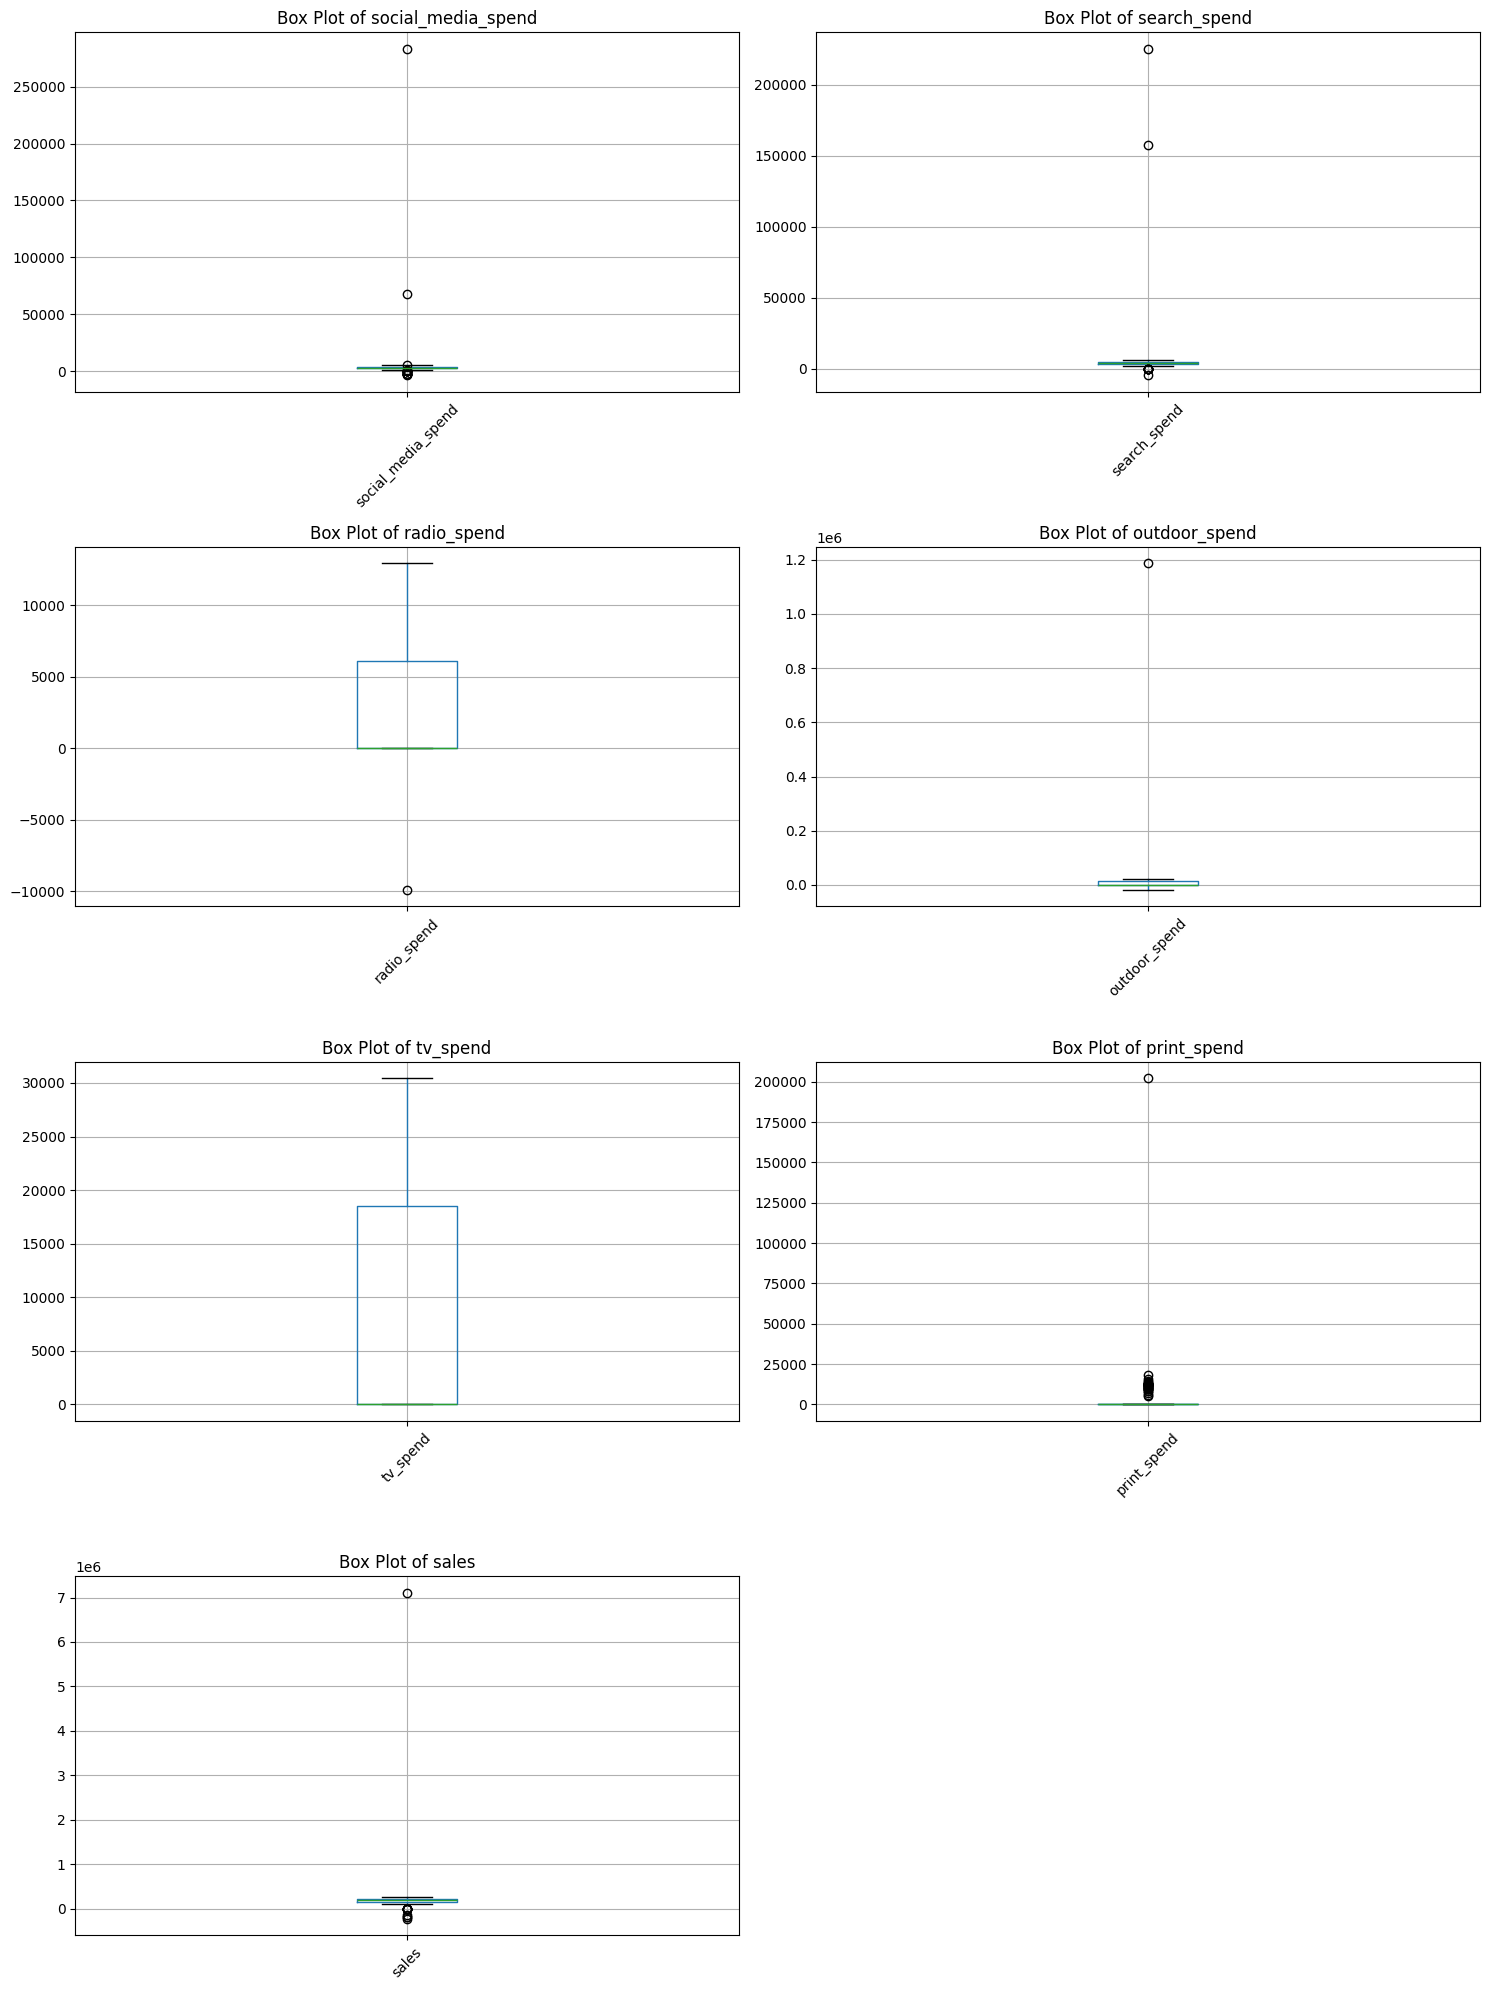

In [10]:
numeric_cols = merged_df.select_dtypes(include=['float64', 'int64']).columns

n_cols = len(numeric_cols)

n_rows = (n_cols + 1) // 2  
fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5*n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    merged_df.boxplot(column=col, ax=axes[i])
    axes[i].set_title(f'Box Plot of {col}')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# 3. Outlier detection and replacing

In [19]:
print('IQR outlier detection')
for col in numeric_cols:
    Q1 = merged_df[col].quantile(0.25)
    Q3 = merged_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = merged_df[(merged_df[col] < lower_bound) | (merged_df[col] > upper_bound)]
    print(f"{col}:")
    print(f"  Outliers: {len(outliers)} ({len(outliers)/len(merged_df)*100:.1f}%)")
    print(f"  Bounds: [{lower_bound:.0f}, {upper_bound:.0f}]")
    print(f"  Max value: {merged_df[col].max():.0f}")
    print()

IQR outlier detection
social_media_spend:
  Outliers: 21 (5.8%)
  Bounds: [613, 5309]
  Max value: 283385

search_spend:
  Outliers: 11 (3.0%)
  Bounds: [1609, 6174]
  Max value: 225600

radio_spend:
  Outliers: 1 (0.3%)
  Bounds: [-9142, 15236]
  Max value: 12934

outdoor_spend:
  Outliers: 1 (0.3%)
  Bounds: [-19902, 33170]
  Max value: 1187040

tv_spend:
  Outliers: 0 (0.0%)
  Bounds: [-27836, 46392]
  Max value: 30466

print_spend:
  Outliers: 34 (9.3%)
  Bounds: [0, 0]
  Max value: 202316

sales:
  Outliers: 13 (3.6%)
  Bounds: [88111, 278982]
  Max value: 7111468



In [12]:
df_clean = merged_df.copy()

print("Outlier Detection and Cleaning Results:")
print("="*50)

for column in merged_df.select_dtypes(include=[np.number]).columns:    
    print(column)
    # Initialize outlier flags
    outliers_to_fix = pd.Series([False] * len(merged_df), index=merged_df.index)
    
    # RULE 1: Extreme highs (20x+ normal)
    normal_high = merged_df[column].quantile(0.95)
    extreme_threshold = normal_high * 20
    extreme_outliers = merged_df[column] > extreme_threshold
    outliers_to_fix |= extreme_outliers
    print(f"  Extreme highs (>{extreme_threshold:,.0f}): {extreme_outliers.sum()}")
    
    # RULE 2: Negative values (impossible for spend/sales)
    negative_outliers = merged_df[column] < 0
    outliers_to_fix |= negative_outliers
    print(f"  Negative values: {negative_outliers.sum()}")
    
    # RULE 3: Zero sales are unrealistic
    zero_issues = pd.Series([False] * len(merged_df), index=merged_df.index)
    if column == 'sales':
        zero_issues = merged_df[column] == 0
        outliers_to_fix |= zero_issues
        print(f"  Zero sales days: {zero_issues.sum()}")
    
    # RULE 4: Existing NaN values
    existing_nan = merged_df[column].isna()
    outliers_to_fix |= existing_nan
    print(f"  Missing values: {existing_nan.sum()}")
    
    # CLEANING: Replace all flagged values with NaN and interpolate
    total_issues = outliers_to_fix.sum()
    if total_issues > 0:
        df_clean.loc[outliers_to_fix, column] = np.nan
        df_clean[column] = df_clean[column].interpolate(method='linear')
        print(f"  → Total values interpolated: {total_issues}")
    else:
        print(f"  → No issues found")
    
    # RESULTS SUMMARY
    print(f"  Original range: {merged_df[column].min():,.0f} to {merged_df[column].max():,.0f}")
    print(f"  Cleaned range:  {df_clean[column].min():,.0f} to {df_clean[column].max():,.0f}")

print(f"\nDataset processed: {len(merged_df)} rows")

# Final cleanup: Fill any remaining NaN values
df_clean = df_clean.fillna(0)
print(f"Final check - Missing values: {df_clean.isna().sum().sum()}")

Outlier Detection and Cleaning Results:
social_media_spend
  Extreme highs (>86,348): 1
  Negative values: 8
  Missing values: 8
  → Total values interpolated: 17
  Original range: -3,654 to 283,385
  Cleaned range:  0 to 68,020
search_spend
  Extreme highs (>106,035): 2
  Negative values: 1
  Missing values: 7
  → Total values interpolated: 10
  Original range: -4,598 to 225,600
  Cleaned range:  0 to 6,165
radio_spend
  Extreme highs (>201,025): 0
  Negative values: 1
  Missing values: 11
  → Total values interpolated: 12
  Original range: -9,907 to 12,934
  Cleaned range:  0 to 12,934
outdoor_spend
  Extreme highs (>363,130): 1
  Negative values: 1
  Missing values: 6
  → Total values interpolated: 8
  Original range: -18,073 to 1,187,040
  Cleaned range:  0 to 22,049
tv_spend
  Extreme highs (>511,902): 0
  Negative values: 0
  Missing values: 7
  → Total values interpolated: 7
  Original range: 0 to 30,466
  Cleaned range:  0 to 30,466
print_spend
  Extreme highs (>232,521): 0
  N

In [ ]:
display(merged_df.describe())

,date,social_media_spend,search_spend,radio_spend,outdoor_spend,tv_spend,print_spend,sales
count,365,357.000000,358.000000,354.000000,3.590000e+02,358.000000,354.000000,3.600000e+02
mean,2022-07-01 23:59:59.999999744,3786.109244,4881.924581,2435.322034,8.992510e+03,8376.321229,1633.242938,1.955590e+05
min,2022-01-01 00:00:00,-3654.000000,-4598.000000,-9907.000000,-1.807300e+04,0.000000,0.000000,-2.355860e+05
25%,2022-04-02 00:00:00,2374.000000,3320.500000,0.000000,0.000000e+00,0.000000,0.000000,1.596880e+05
50%,2022-07-02 00:00:00,2996.000000,3938.500000,0.000000,0.000000e+00,0.000000,0.000000,1.836975e+05
75%,2022-10-01 00:00:00,3548.000000,4461.750000,6094.500000,1.326800e+04,18557.000000,0.000000,2.074058e+05
max,2022-12-31 00:00:00,283385.000000,225600.000000,12934.000000,1.187040e+06,30466.000000,202316.000000,7.111468e+06
std,NaN,15287.052063,14279.910696,3915.324561,6.279623e+04,10329.322304,11226.010232,3.699124e+05


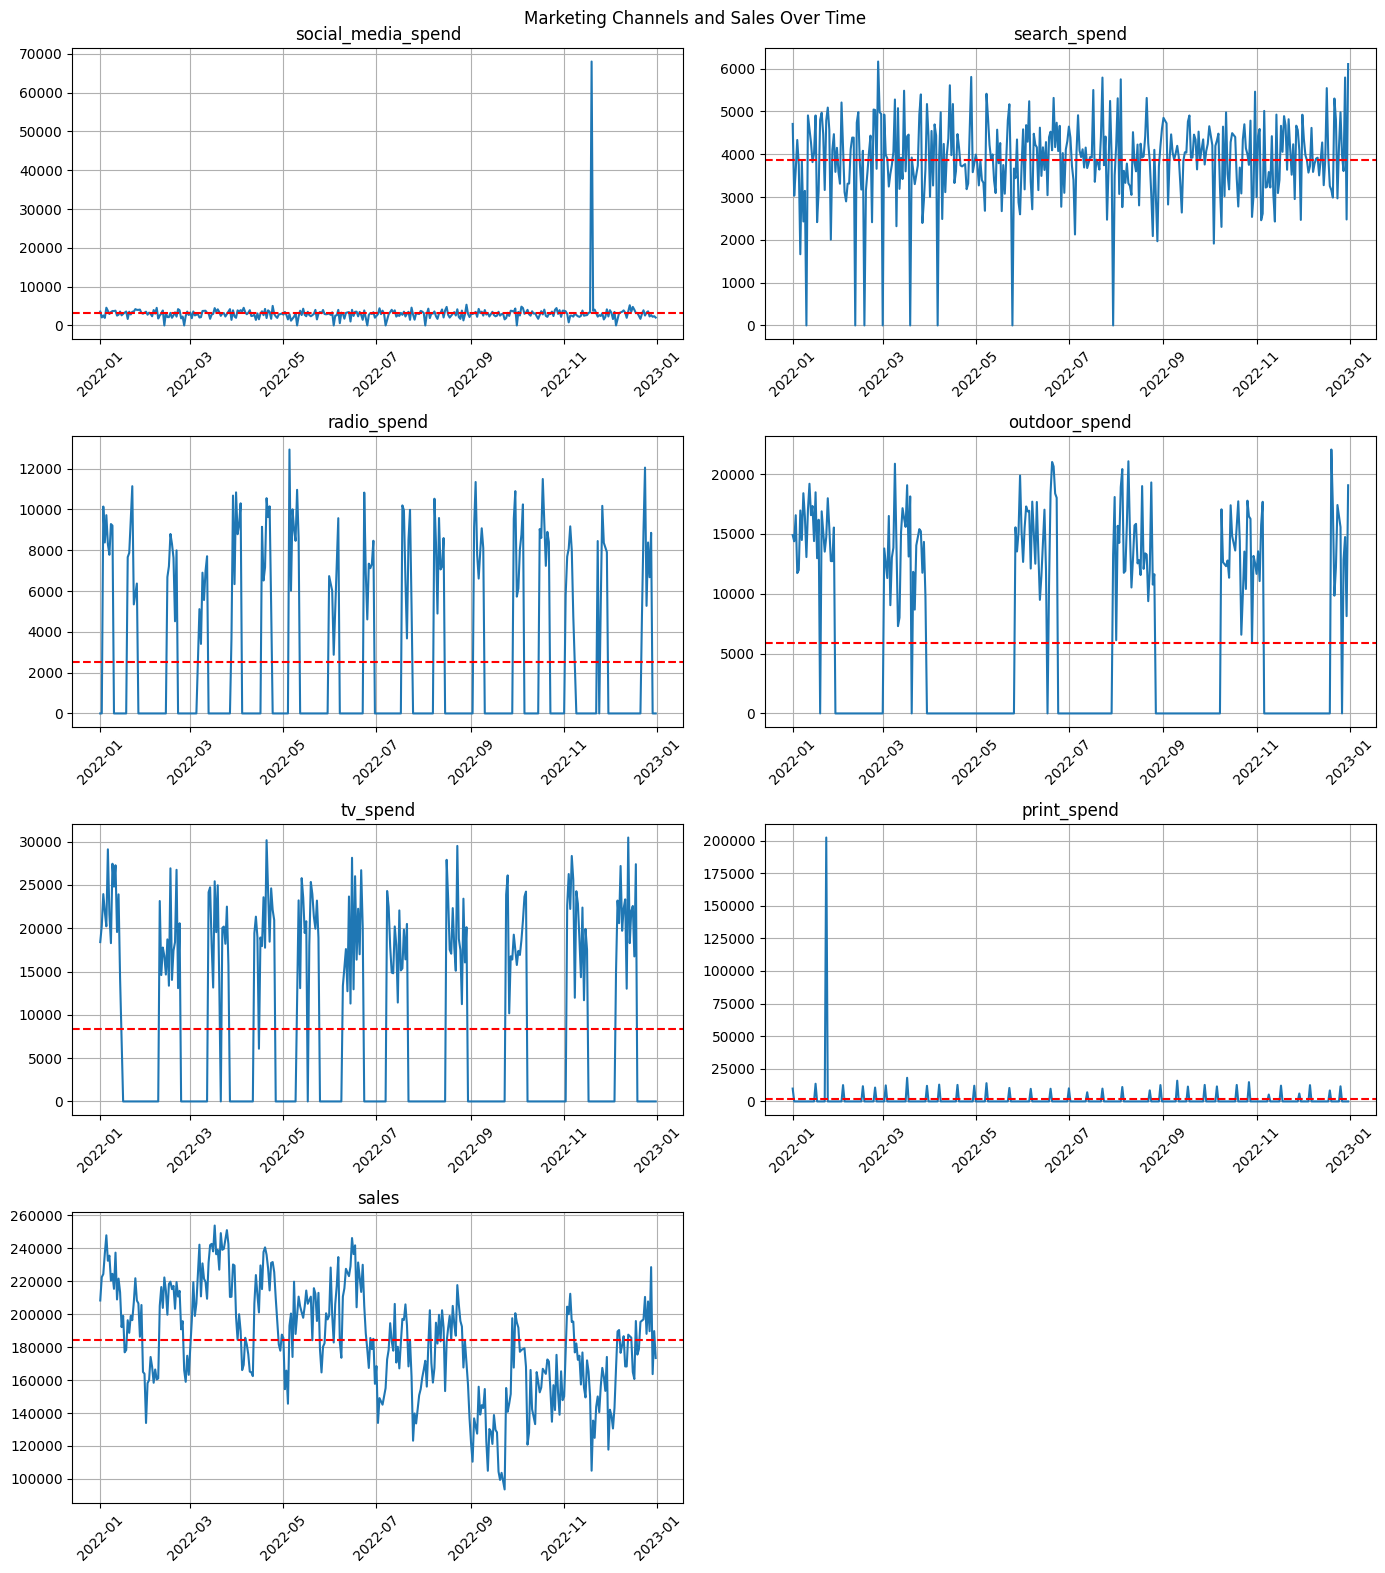

In [13]:
fig, axes = plt.subplots(4, 2, figsize=(14, 16))
fig.suptitle("Marketing Channels and Sales Over Time")

axes = axes.flatten()

for i, col in enumerate([col for col in df_clean.columns if col != 'date']):
    if i < 7:  
        ax = axes[i]
        ax.plot(df_clean['date'], df_clean[col], label=col)
        ax.axhline(y=df_clean[col].mean(), color='r', linestyle='--', label='Mean')
        ax.set_title(col)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True)

fig.delaxes(axes[7])

plt.tight_layout()
plt.show()


In [ ]:
display(merged_df.describe())

,date,social_media_spend,search_spend,radio_spend,outdoor_spend,tv_spend,print_spend,sales
count,365,357.000000,358.000000,354.000000,3.590000e+02,358.000000,354.000000,3.600000e+02
mean,2022-07-01 23:59:59.999999744,3786.109244,4881.924581,2435.322034,8.992510e+03,8376.321229,1633.242938,1.955590e+05
min,2022-01-01 00:00:00,-3654.000000,-4598.000000,-9907.000000,-1.807300e+04,0.000000,0.000000,-2.355860e+05
25%,2022-04-02 00:00:00,2374.000000,3320.500000,0.000000,0.000000e+00,0.000000,0.000000,1.596880e+05
50%,2022-07-02 00:00:00,2996.000000,3938.500000,0.000000,0.000000e+00,0.000000,0.000000,1.836975e+05
75%,2022-10-01 00:00:00,3548.000000,4461.750000,6094.500000,1.326800e+04,18557.000000,0.000000,2.074058e+05
max,2022-12-31 00:00:00,283385.000000,225600.000000,12934.000000,1.187040e+06,30466.000000,202316.000000,7.111468e+06
std,NaN,15287.052063,14279.910696,3915.324561,6.279623e+04,10329.322304,11226.010232,3.699124e+05


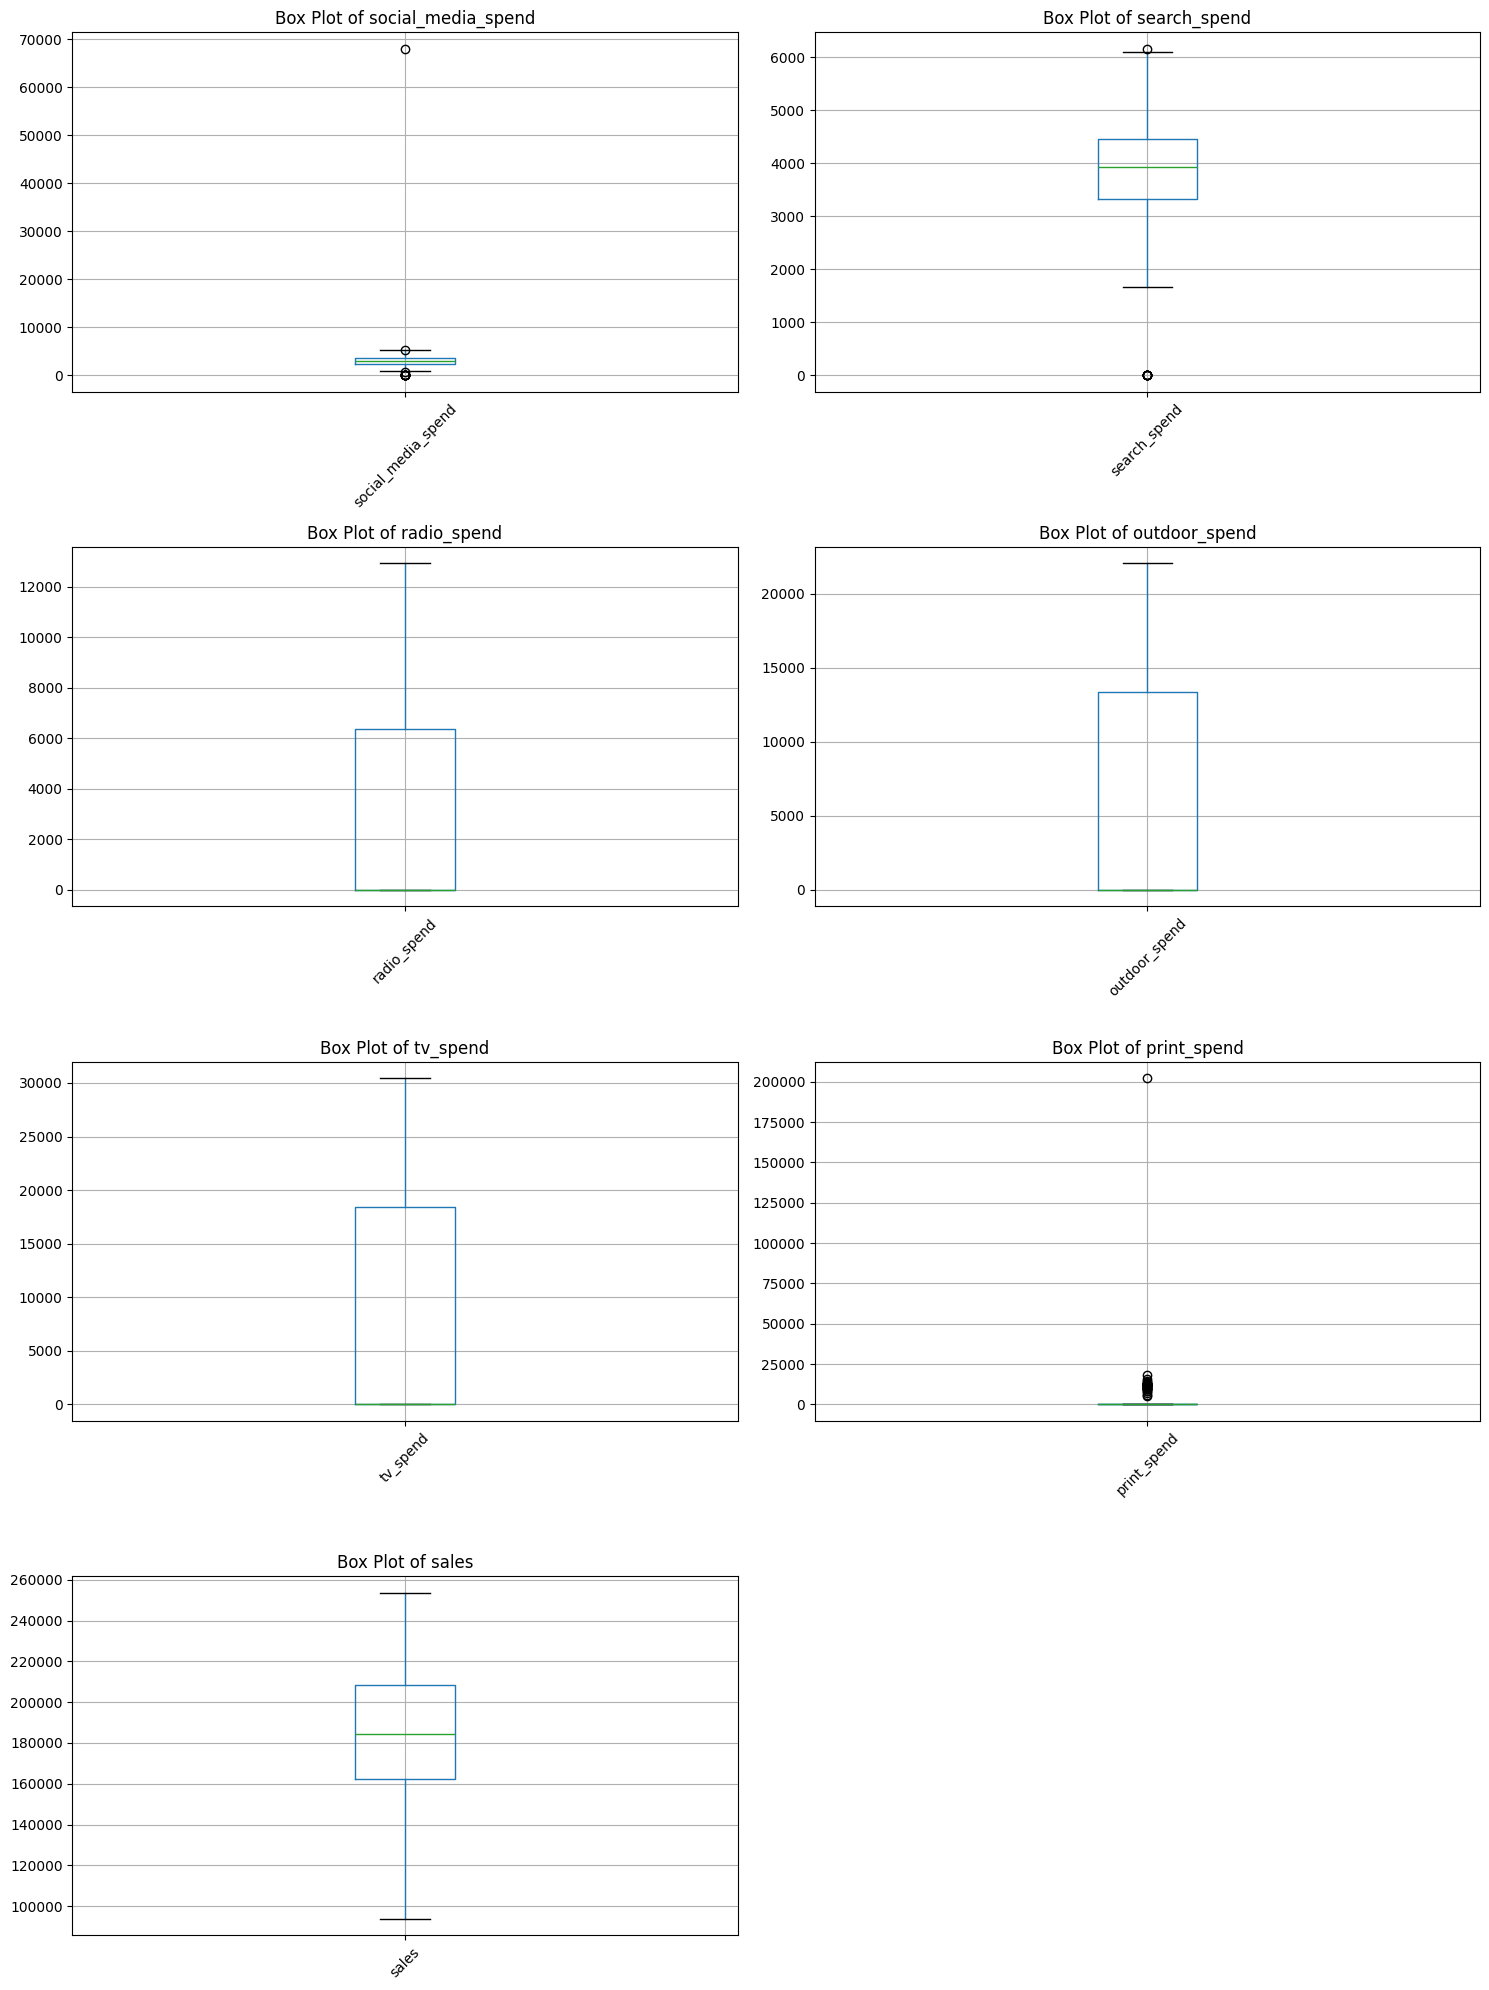

In [14]:
n_rows = (n_cols + 1) // 2  
fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5*n_rows))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    df_clean.boxplot(column=col, ax=axes[i])
    axes[i].set_title(f'Box Plot of {col}')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [15]:
print("Negative values:\n", (df_clean.drop(columns=['date']) < 0).sum())
print("\nMissing values:\n", df_clean.isna().sum())

Negative values:
 social_media_spend    0
search_spend          0
radio_spend           0
outdoor_spend         0
tv_spend              0
print_spend           0
sales                 0
dtype: int64

Missing values:
 date                  0
social_media_spend    0
search_spend          0
radio_spend           0
outdoor_spend         0
tv_spend              0
print_spend           0
sales                 0
dtype: int64


In [16]:
df_clean = df_clean.fillna(0)

print("\nAfter filling NaN values with 0:")
print("Missing values:\n", df_clean.isna().sum())



After filling NaN values with 0:
Missing values:
 date                  0
social_media_spend    0
search_spend          0
radio_spend           0
outdoor_spend         0
tv_spend              0
print_spend           0
sales                 0
dtype: int64


In [17]:
# Calculate correlations with sales
correlations = df_clean.drop(columns=['date']).corr()['sales'].sort_values(ascending=False)
print("\nCorrelations with sales:")
print(correlations)


Correlations with sales:
sales                 1.000000
tv_spend              0.503080
outdoor_spend         0.365100
radio_spend           0.213998
print_spend           0.066414
search_spend         -0.034627
social_media_spend   -0.118681
Name: sales, dtype: float64


In [18]:
display(df_clean.describe())

,date,social_media_spend,search_spend,radio_spend,outdoor_spend,tv_spend,print_spend,sales
count,365,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,2022-07-01 23:59:59.999999744,3117.905479,3861.945205,2544.138356,5874.420548,8381.434247,1584.021918,184206.252055
min,2022-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,93619.000000
25%,2022-04-02 00:00:00,2432.000000,3330.000000,0.000000,0.000000,0.000000,0.000000,162384.000000
50%,2022-07-02 00:00:00,3008.000000,3936.500000,0.000000,0.000000,0.000000,0.000000,184513.000000
75%,2022-10-01 00:00:00,3549.000000,4458.000000,6367.000000,13373.000000,18440.000000,0.000000,208284.000000
max,2022-12-31 00:00:00,68020.000000,6165.000000,12934.000000,22049.000000,30466.000000,202316.000000,253770.000000
std,NaN,3528.094003,976.134975,3873.455353,7408.347832,10304.357144,11058.620642,32891.000722
